<a href="https://colab.research.google.com/github/ashrikant39/Histopatgology-Image-Classification/blob/main/Inception_ResNet_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [126]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
from torchsummary import summary
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import os
import math
import cv2

In [127]:
!pip install pkbar
import pkbar

In [128]:
batch_size= 32
device = 'cuda'
num_classes= 4
input_shape=(3,224,224)
learning_rate=5e-6
num_epochs= 100

In [129]:
main_path= 'drive/My Drive/Hist_folder/KMC Dataset'
train_dir= os.path.join(main_path,'Training')
test_dir= os.path.join(main_path,'Test')
val_dir= os.path.join(main_path,'Validation')

check_pt_file= os.path.join(main_path, 'Inception_ResNet_V2_Checkpoint_3.pth.tar')

print(os.listdir(main_path))
print(os.listdir(train_dir))
print(os.listdir(test_dir))
print(os.listdir(val_dir))

['Training', 'Validation', 'Test', 'ResNet50_Checkpoint_1.pth.tar', 'AlexNet.ipynb', 'AlexNet_checkpoint.pth.tar', 'DenseNet.ipynb', 'ResNet50_Checkpoint_2.pth.tar', 'ResNet50_Checkpoint_3.pth.tar', 'ResNet50_Checkpoint_4.pth.tar', 'ResNet50_Checkpoint_5.pth.tar', 'ResNet50_Checkpoint_6.pth.tar', 'ResNet50.ipynb', 'Inception_ResNet_V2_Checkpoint_1.pth.tar', 'Inception_ResNet_V2_Checkpoint_2.pth.tar', 'Inception_ResNet_V2.ipynb', 'Inception_ResNet_V2_Checkpoint_3.pth.tar', 'Inception_ResNet_V2_Checkpoint_4.pth.tar']
['grade1', 'grade3', 'grade2', 'grade0']
['grade1', 'grade0', 'grade2', 'grade3']
['grade2', 'grade1', 'grade0', 'grade3']


In [130]:
my_transforms = transforms.Compose([ #Compose makes it possible to have many transforms
    transforms.ColorJitter(brightness=0.3, contrast=0.3), # Change brightness of image
    transforms.RandomRotation(degrees=60), # Perhaps a random rotation from -45 to 45 degrees
    transforms.RandomHorizontalFlip(p=0.5), # Flips the image horizontally with probability 0.5
    transforms.RandomVerticalFlip(p=0.05), # Flips image vertically with probability 0.05
    transforms.ToTensor() # Finally converts PIL image to tensor so we can train w. pytorch
    ])


In [131]:
train_data= datasets.ImageFolder(train_dir, transform= my_transforms)
test_data= datasets.ImageFolder(test_dir, transform= transforms.ToTensor())
val_data= datasets.ImageFolder(val_dir, transform= transforms.ToTensor())

In [132]:
train_loader= DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader= DataLoader(test_data, batch_size=batch_size, shuffle=True)
val_loader= DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [133]:
class_dict=train_data.class_to_idx
class_labels = class_dict.values()
print(class_labels)

dict_values([0, 1, 2, 3])


### Plotting the images with classes



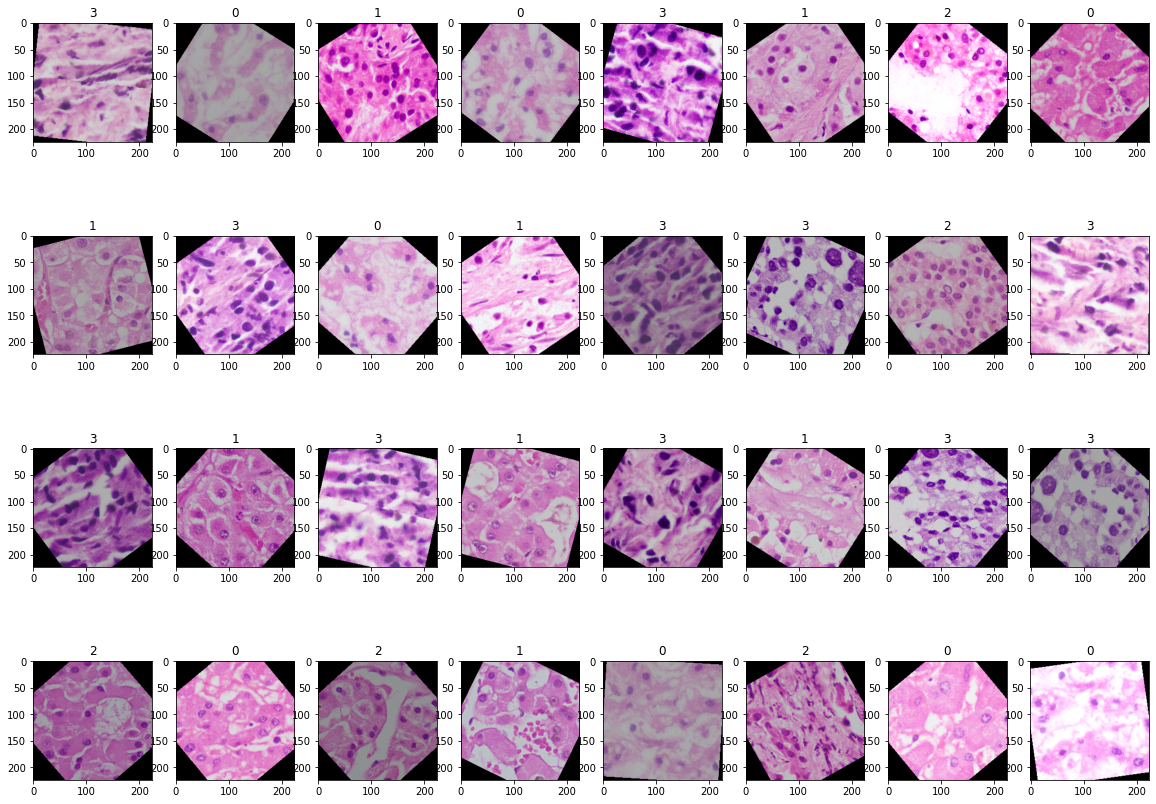

In [134]:
iterator= iter(train_loader)
it= next(iterator)
images, labels= it

plt.figure(figsize=(20,15))
for r in range(batch_size):
    plt.subplot(4,8,r+1)
    f= plt.imshow(images[r].permute(2,1,0))
    plt.title(labels[r].item())
plt.show()

## Model Definition

In [ ]:
class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, stride=1, bias=True):
        super(Conv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0.1)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

In [ ]:
class Stem(nn.Module):
    def __init__(self, in_channels):
        super(Stem, self).__init__()
        self.features = nn.Sequential(
            Conv2d(in_channels, 32, 3, stride=2, padding=0, bias=False), 
            Conv2d(32, 32, 3, stride=1, padding=0, bias=False), 
            Conv2d(32, 64, 3, stride=1, padding=1, bias=False), 
            nn.MaxPool2d(3, stride=2, padding=0), 
            Conv2d(64, 80, 1, stride=1, padding=0, bias=False), 
            Conv2d(80, 192, 3, stride=1, padding=0, bias=False), 
            nn.MaxPool2d(3, stride=2, padding=0), 
        )
        self.branch_0 = Conv2d(192, 96, 1, stride=1, padding=0, bias=False)
        self.branch_1 = nn.Sequential(
            Conv2d(192, 48, 1, stride=1, padding=0, bias=False),
            Conv2d(48, 64, 5, stride=1, padding=2, bias=False),
        )
        self.branch_2 = nn.Sequential(
            Conv2d(192, 64, 1, stride=1, padding=0, bias=False),
            Conv2d(64, 96, 3, stride=1, padding=1, bias=False),
            Conv2d(96, 96, 3, stride=1, padding=1, bias=False),
        )
        self.branch_3 = nn.Sequential(
            nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False),
            Conv2d(192, 64, 1, stride=1, padding=0, bias=False)
        )
    def forward(self, x):
        x = self.features(x)
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x2 = self.branch_2(x)
        x3 = self.branch_3(x)
        return torch.cat((x0, x1, x2, x3), dim=1)

In [ ]:
class Inception_ResNet_A(nn.Module):
    def __init__(self, in_channels, scale=1.0):
        super(Inception_ResNet_A, self).__init__()
        self.scale = scale
        self.branch_0 = Conv2d(in_channels, 32, 1, stride=1, padding=0, bias=False)
        self.branch_1 = nn.Sequential(
            Conv2d(in_channels, 32, 1, stride=1, padding=0, bias=False),
            Conv2d(32, 32, 3, stride=1, padding=1, bias=False)
        )
        self.branch_2 = nn.Sequential(
            Conv2d(in_channels, 32, 1, stride=1, padding=0, bias=False),
            Conv2d(32, 48, 3, stride=1, padding=1, bias=False),
            Conv2d(48, 64, 3, stride=1, padding=1, bias=False)
        )
        self.conv = nn.Conv2d(128, 320, 1, stride=1, padding=0, bias=True)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x2 = self.branch_2(x)
        x_res = torch.cat((x0, x1, x2), dim=1)
        x_res = self.conv(x_res)
        return self.relu(x + self.scale * x_res)

In [ ]:
class Inception_ResNet_B(nn.Module):
    def __init__(self, in_channels, scale=1.0):
        super(Inception_ResNet_B, self).__init__()
        self.scale = scale
        self.branch_0 = Conv2d(in_channels, 192, 1, stride=1, padding=0, bias=False)
        self.branch_1 = nn.Sequential(
            Conv2d(in_channels, 128, 1, stride=1, padding=0, bias=False),
            Conv2d(128, 160, (1, 7), stride=1, padding=(0, 3), bias=False),
            Conv2d(160, 192, (7, 1), stride=1, padding=(3, 0), bias=False)
        )
        self.conv = nn.Conv2d(384, 1088, 1, stride=1, padding=0, bias=True)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x_res = torch.cat((x0, x1), dim=1)
        x_res = self.conv(x_res)
        return self.relu(x + self.scale * x_res)

In [ ]:
class Inception_ResNet_C(nn.Module):
    def __init__(self, in_channels, scale=1.0, activation=True):
        super(Inception_ResNet_C, self).__init__()
        self.scale = scale
        self.activation = activation
        self.branch_0 = Conv2d(in_channels, 192, 1, stride=1, padding=0, bias=False)
        self.branch_1 = nn.Sequential(
            Conv2d(in_channels, 192, 1, stride=1, padding=0, bias=False),
            Conv2d(192, 224, (1, 3), stride=1, padding=(0, 1), bias=False),
            Conv2d(224, 256, (3, 1), stride=1, padding=(1, 0), bias=False)
        )
        self.conv = nn.Conv2d(448, 2080, 1, stride=1, padding=0, bias=True)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x_res = torch.cat((x0, x1), dim=1)
        x_res = self.conv(x_res)
        if self.activation:
            return self.relu(x + self.scale * x_res)
        return x + self.scale * x_res

In [ ]:
class Reduction_A(nn.Module):
    # 35 -> 17
    def __init__(self, in_channels, k, l, m, n):
        super(Reduction_A, self).__init__()
        self.branch_0 = Conv2d(in_channels, n, 3, stride=2, padding=0, bias=False)
        self.branch_1 = nn.Sequential(
            Conv2d(in_channels, k, 1, stride=1, padding=0, bias=False),
            Conv2d(k, l, 3, stride=1, padding=1, bias=False),
            Conv2d(l, m, 3, stride=2, padding=0, bias=False),
        )
        self.branch_2 = nn.MaxPool2d(3, stride=2, padding=0)

    def forward(self, x):
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x2 = self.branch_2(x)
        return torch.cat((x0, x1, x2), dim=1) # 17 x 17 x 1024

In [ ]:
class Reduciton_B(nn.Module):
    def __init__(self, in_channels):
        super(Reduciton_B, self).__init__()
        self.branch_0 = nn.Sequential(
            Conv2d(in_channels, 256, 1, stride=1, padding=0, bias=False),
            Conv2d(256, 384, 3, stride=2, padding=0, bias=False)
        )
        self.branch_1 = nn.Sequential(
            Conv2d(in_channels, 256, 1, stride=1, padding=0, bias=False),
            Conv2d(256, 288, 3, stride=2, padding=0, bias=False),
        )
        self.branch_2 = nn.Sequential(
            Conv2d(in_channels, 256, 1, stride=1, padding=0, bias=False),
            Conv2d(256, 288, 3, stride=1, padding=1, bias=False),
            Conv2d(288, 320, 3, stride=2, padding=0, bias=False)
        )
        self.branch_3 = nn.MaxPool2d(3, stride=2, padding=0)

    def forward(self, x):
        x0 = self.branch_0(x)
        x1 = self.branch_1(x)
        x2 = self.branch_2(x)
        x3 = self.branch_3(x)
        return torch.cat((x0, x1, x2, x3), dim=1)

In [ ]:
class Inception_ResNet_V2(nn.Module):
    def __init__(self, in_channels=3, num_classes=1000, k=256, l=256, m=384, n=384):
        super(Inception_ResNet_V2, self).__init__()
        blocks = []
        blocks.append(Stem(in_channels))
        for i in range(10):
            blocks.append(Inception_ResNet_A(320, 0.17))
        blocks.append(Reduction_A(320, k, l, m, n))
        for i in range(20):
            blocks.append(Inception_ResNet_B(1088, 0.10))
        blocks.append(Reduciton_B(1088))
        for i in range(9):
            blocks.append(Inception_ResNet_C(2080, 0.20))
        blocks.append(Inception_ResNet_C(2080, activation=False))
        self.features = nn.Sequential(*blocks)
        self.conv = Conv2d(2080, 1536, 1, stride=1, padding=0, bias=False)
        self.global_average_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(1536, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.conv(x)
        x = self.global_average_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

In [ ]:
model= Inception_ResNet_V2(num_classes=4).to(device)
summary(model, input_size= (3,224,224), batch_size=batch_size, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 32, 111, 111]             864
       BatchNorm2d-2         [32, 32, 111, 111]              64
              ReLU-3         [32, 32, 111, 111]               0
            Conv2d-4         [32, 32, 111, 111]               0
            Conv2d-5         [32, 32, 109, 109]           9,216
       BatchNorm2d-6         [32, 32, 109, 109]              64
              ReLU-7         [32, 32, 109, 109]               0
            Conv2d-8         [32, 32, 109, 109]               0
            Conv2d-9         [32, 64, 109, 109]          18,432
      BatchNorm2d-10         [32, 64, 109, 109]             128
             ReLU-11         [32, 64, 109, 109]               0
           Conv2d-12         [32, 64, 109, 109]               0
        MaxPool2d-13           [32, 64, 54, 54]               0
           Conv2d-14           [32, 80,

In [ ]:
Loss= nn.CrossEntropyLoss()
optimizer= optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def check_accuracy(scores, targets):

  num_correct=0
  num_samples=0
  _, predictions= scores.max(1)
  num_correct+= (predictions== targets).sum()
  num_samples= predictions.size(0)

  return num_correct/num_samples

In [ ]:
def save_checkpoint(model, optimizer, file_name):

  checkpoint= {'state_dict': model.state_dict(),
             'optimizer_dict': optimizer.state_dict()}
  torch.save(checkpoint,file_name)

def load_checkpoint(model, optimizer, file_name):
  check_pt= torch.load(file_name)
  model.load_state_dict(check_pt['state_dict'])
  optimizer.load_state_dict(check_pt['optimizer_dict'])

  return model, optimizer

In [ ]:
train_per_epoch= len(train_loader)
val_per_epoch= len(val_loader)
min_loss= math.inf



for epoch in range(num_epochs):
  train_losses=[]
### TRAINING

  kbar_train= pkbar.Kbar(target= train_per_epoch, epoch=epoch, num_epochs=num_epochs)

  train_loop= enumerate(train_loader)
  val_loop= enumerate(val_loader)
  for batch_idx, (data,targets) in train_loop:

    model.train()

    data= data.to(device=device)
    targets= targets.to(device=device)

    # FORWARD PROP

    scores= model(data)
    train_loss= Loss(scores, targets)
    train_losses.append(train_loss.item())

    # BACKWARD PROP
    optimizer.zero_grad()
    train_loss.backward()

    optimizer.step()

    train_acc= check_accuracy(scores,targets)

    kbar_train.update(batch_idx, values=[("loss", train_loss.item()), ("accuracy", train_acc.item())])

  kbar_train.update(train_per_epoch, values=None)
### VALIDATION

  kbar_val= pkbar.Kbar(target= val_per_epoch, epoch=epoch, num_epochs=num_epochs)


  for batch_idx, (data, targets) in val_loop:

    val_losses=[]
    model.eval()

    
    data= data.to(device=device)
    targets= targets.to(device=device)
    scores= model(data)
    val_loss= Loss(scores, targets)
    val_losses.append(val_loss.item())
    val_acc= check_accuracy(scores,targets)

    kbar_val.update(batch_idx, values=[("val_loss", val_loss.item()), ("val_accuracy", val_acc.item())])

  if np.mean(val_losses)<min_loss:
    min_loss= val_loss.item()
    print('\nImproved validation loss: {:.4f}'.format(val_loss.item()))
    print('Saving the model to {}\n'.format(check_pt_file))
    save_checkpoint(model, optimizer, check_pt_file)
    
  kbar_val.update(val_per_epoch, values=None)

In [ ]:
def CONFUSION_MATRIX(y_true, y_pred, class_labels, order=False):
  
  num_classes= len(class_labels)
  num_examples= len(y_true)

  if order is False:
    new_labels= np.arange(num_classes)
    
    for i in range(num_examples):
      y_true[i].item= np.where(class_labels==y_true[i])[0]
      y_pred[i].item= np.where(class_labels==y_pred[i])[0]

  mat= np.zeros((num_classes,num_classes), dtype=np.int)
  
  for i in range(num_examples):
    true= np.uint8(y_true[i].item())
    pred= np.uint8(y_pred[i].item())

    mat[true,pred]+=1

  return mat


def acc_precision_recall_f1(confusion_matrix):

  num_classes= confusion_matrix.shape[0]
  precision=      np.zeros((num_classes,1), np.float64)
  recall=         np.zeros((num_classes,1), np.float64)
  true_positives= np.zeros((num_classes,1), np.float64)
  true_negatives= np.zeros((num_classes,1), np.float64)
  accuracy=       np.zeros((num_classes,1), np.float64)
  f1=             np.zeros((num_classes,1), np.float64)

  for i in range(num_classes):
    
    true_positives[i]= confusion_matrix[i,i]
    precision[i]= confusion_matrix[i,i]/np.sum(confusion_matrix[i])
    recall[i]= confusion_matrix[i,i]/np.sum(confusion_matrix[:,i])
    f1[i]= 2*precision[i]*recall[i]/(precision[i]+recall[i])
  

  for i in range(num_classes):
    true_negatives[i]=0
    for j in range(num_classes):
      for k in range(num_classes):
        if (j!=i) and (k!=i):
          true_negatives[i]+=confusion_matrix[j,k]

  accuracy= (true_positives+true_negatives)/np.sum(confusion_matrix)
  return accuracy, precision, recall, f1


def Final_Metrics(loader, model, class_labels):

    model.eval()
    size= len(class_labels)
    c_mat= np.zeros((size,size), dtype= np.int)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores= model(x)
            _, preds = scores.max(1)

            c_mat+= CONFUSION_MATRIX(y, preds, class_labels, order= True)
    
    accuracy, precision, recall, f1= acc_precision_recall_f1(c_mat)

    return c_mat, accuracy, precision, recall, f1

In [ ]:
incep_resnet, _= load_checkpoint(model, optimizer, check_pt_file)

In [ ]:
confusion_matrix, accuracy, precision, recall, f1= Final_Metrics(test_loader, incep_resnet, class_labels)

In [ ]:
print(confusion_matrix)

[[70  0  0  0]
 [ 0 78  2  0]
 [ 0 14 66  0]
 [ 0  0  5 45]]


In [ ]:
print(precision.T)
print(np.mean(precision))

print(recall.T)
print(np.mean(recall))

print(f1.T)
print(np.mean(f1))

print(accuracy.T)
print(np.mean(accuracy))

[[1.    0.975 0.825 0.9  ]]
0.9249999999999999
[[1.         0.84782609 0.90410959 1.        ]]
0.9379839189994044
[[1.         0.90697674 0.8627451  0.94736842]]
0.9292725658194736
[[1.         0.94285714 0.925      0.98214286]]
0.9625
